# QPEP analysis

This notebook looks at the results from the qpep performance analysis in the opensand testbed.

In [131]:
import numpy as np
import matplotlib.pyplot as plt
import pickle, os
import re
import matplotlib.colors as mcolors

plt.rcParams['text.usetex'] = True

For each bottleneck bandwidth, I want to plot throughput (i.e. sent bps) against: delays or plr (on two different plots). On the same plot, we have qpep and plain for the 3 different file sizes. Put confidence intervals around the datapoints of one of the file sizes.

I should create a dictionnary with
```bash
bandwidths
|-plr
|--delay
|---filesize [10kbps,100kbps,10mbps]
```


In [132]:
error_percentages = [0,0.01,0.5,1] #that is in packet error
file_sizes = [1e4,1e5,1e7]#in bytes
bandwidths = [7e2,1e4,4e5]#in kbps
delays = [1,10,50,100,250]#Added delay on the satellite link (=RTT/4)

def average_bps(file_path):
    try:
        data = np.loadtxt(file_path)
        # only take values after time is more than 100
        return np.average(data[data[:,0] > 100])
    except: 
        return 0

def get_error(file_path):
    match = re.search(r"_([.\d]*)plr_", file_path)
    if not match: 
        print(f"Error: Error not found in {file_path}")
        return None
    return match.group(1)

def get_delay(file_path):
    match = re.search(r"_(\d+?[\.\d]*?)ms_",file_path)
    if not match: 
        print(f"Error: Delay not found in {file_path}")
        return None
    return match.group(1)

def get_bandwidth(file_path):
    match = re.search(r"_(\d+?.\d+?kbps)_",file_path)
    if not match: 
        print(f"Error: Bandwidth not found in {file_path}")
        return None
    return match.group(1)

def filesize_to_number(name):
    match = re.search(r"iperf_(.*?)mb",name)
    if not match:
        print(f"Error: number not found in {name}")
        return None
    return match.group(1)

In [128]:
def plot_throughput(ax, results = {}, bw = '400000kbps',rtt = None, error = None, scenario="",filesize="",colour='red',linestyle=''):
    """Plot the qpep experiments results
    Specify either one error to plot against rtt or one rtt to plot against error
    """
    # Maybe assert that it is a valid rtt
    # assert(results[bw][].keys)
    # Points is an array containing the points to plot
    # every row is a point, which has: an x-value (the error rate), a y-value(the send bps median), a lower error, an upper error
    if rtt is not None:
        points = np.zeros((len(results[bw].keys()),4)) #we have this many different errors
        for j,error in enumerate(results[bw].keys()):
            points[j,:] = float(error)/10 , np.median(results[bw][error][rtt][filesize]), np.min(results[bw][error][rtt][filesize]), np.max(results[bw][error][rtt][filesize])
        
    elif error is not None:
        points = np.zeros((len(results[bw][error].keys()),4)) #we have this many different rtts
        for j,rtt in enumerate(results[bw][error].keys()):
            points[j,:] = float(rtt)*4 , np.median(results[bw][error][rtt][filesize]), np.min(results[bw][error][rtt][filesize]), np.max(results[bw][error][rtt][filesize])
    #reorder the points by x-value
    points = points[points[:,0].argsort()]
    ax.errorbar(points[:,0],points[:,1], yerr=[abs(points[:,1]-points[:,2]), abs(points[:,3]-points[:,1])], fmt='none', capsize=5,alpha=0.5,color=colour)
    ax.plot(points[:,0],points[:,1],label=f'{scenario},filesize {filesize}mb',marker='x', markerfacecolor="none", markersize = '4',linestyle=linestyle,color=colour)
    return

In [136]:
cca = "Opensand emulation"


def get_results_from_folder_path(folder_path):
    # Get a list of all files in the folder
    file_list = os.listdir(folder_path)
    # Create dictionary to store the average for each error, rtt, and run
    results = {}
    for i,filename in enumerate(file_list):
        bandwidth = get_bandwidth(f'{folder_path}{filename}')
        error = get_error(f'{folder_path}{filename}')
        rtt = get_delay(f'{folder_path}{filename}')
        if bandwidth not in results:
            results[bandwidth] = {}
        if error not in results[bandwidth]:
            results[bandwidth][error] = {}
        if rtt not in results[bandwidth][error]:
            results[bandwidth][error][rtt] = {}
        file = open(f'{folder_path}{filename}','rb')
        data = pickle.load(file)
        for filesize in data.keys():
            results[bandwidth][error][rtt][filesize_to_number(filesize)] = np.array(data[filesize]['received_bps'])/1e6
        file.close()
    return results

# sort the dictionary by error key
# results[bw] = dict(sorted(results[bw].items()))

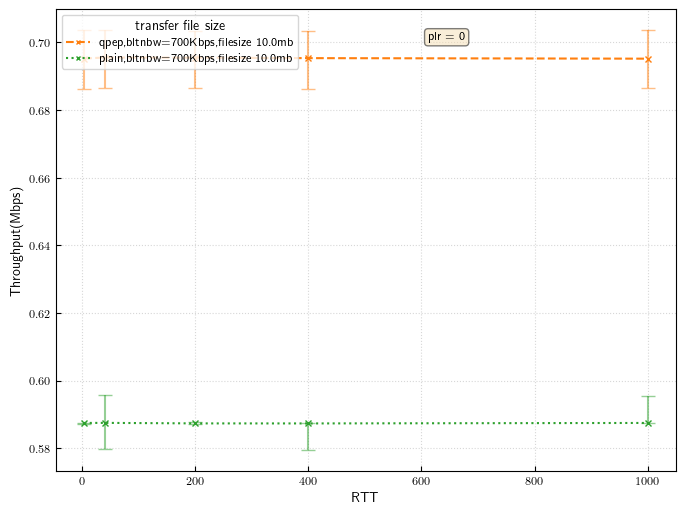

In [137]:
error = '0'
my_colours = list(mcolors.TABLEAU_COLORS.values())
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig, ax = plt.subplots(1,1,figsize=(8,6))
bw = '700.0kbps'
results = get_results_from_folder_path("./qpep_results/18.08.23/qpep_iperf/")
plot_throughput(ax,results,bw=bw,error=error, scenario = 'qpep,bltnbw=700Kbps',filesize='10.0',colour = my_colours[1], linestyle='--')
results = get_results_from_folder_path("./qpep_results/18.08.23/plain_iperf/")
plot_throughput(ax,results,bw=bw,error=error, scenario ='plain,bltnbw=700Kbps',filesize='10.0',colour = my_colours[2],linestyle=':')
# bw = '10000.0kbps'
# results = get_results_from_folder_path("./qpep_results/18.08.23/qpep_iperf/")
# plot_throughput(ax,results,bw=bw,error=error, scenario = 'qpep,bltnbw=10Mbps',filesize='10.0',colour = my_colours[3])
# results = get_results_from_folder_path("./qpep_results/18.08.23/plain_iperf/")
# plot_throughput(ax,results,bw=bw,error=error, scenario ='plain,bltnbw=10Mbps',filesize='10.0',colour = my_colours[4])
# bw = '400000.0kbps'
# results = get_results_from_folder_path("./qpep_results/18.08.23/qpep_iperf/")
# plot_throughput(ax,results,bw=bw,error=error, scenario = 'qpep,bltnbw=400Mbps',filesize='10.0',colour = my_colours[5])
# results = get_results_from_folder_path("./qpep_results/18.08.23/plain_iperf/")
# plot_throughput(ax,results,bw=bw,error=error, scenario ='plain,bltnbw=400Mbps',filesize='10.0',colour = my_colours[6])
ax.text(0.6, 0.95, f"plr = {error}", transform=ax.transAxes, fontsize="small", verticalalignment='top', bbox=props)
plt.tick_params(axis='both', direction='in',labelsize="small", grid_alpha=0.5, grid_linestyle=':')
ax.legend(title=f"transfer file size",loc='upper left',fontsize="small", markerscale=0.6)
ax.set_xlabel("RTT")
ax.set_ylabel("Throughput(Mbps)")
ax.grid()
plt.show()

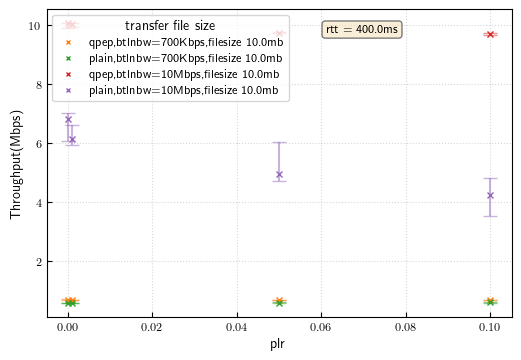

In [138]:
delay = '100'
my_colours = list(mcolors.TABLEAU_COLORS.values())
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig, ax = plt.subplots(1,1,figsize=(6,4))
bw = '700.0kbps'
results = get_results_from_folder_path("./qpep_results/18.08.23/qpep_iperf/")
plot_throughput(ax,results,bw=bw,rtt=delay, scenario = 'qpep,btlnbw=700Kbps',filesize='10.0',colour = my_colours[1])
results = get_results_from_folder_path("./qpep_results/18.08.23/plain_iperf/")
plot_throughput(ax,results,bw=bw,rtt = delay, scenario ='plain,btlnbw=700Kbps',filesize='10.0',colour = my_colours[2])
bw = '10000.0kbps'
results = get_results_from_folder_path("./qpep_results/18.08.23/qpep_iperf/")
plot_throughput(ax,results,bw=bw,rtt=delay, scenario = 'qpep,btlnbw=10Mbps',filesize='10.0',colour = my_colours[3])
results = get_results_from_folder_path("./qpep_results/18.08.23/plain_iperf/")
plot_throughput(ax,results,bw=bw,rtt = delay, scenario ='plain,btlnbw=10Mbps',filesize='10.0',colour = my_colours[4])
ax.text(0.6, 0.95, f"rtt = {float(delay)*4}ms", transform=ax.transAxes, fontsize="small", verticalalignment='top', bbox=props)
plt.tick_params(axis='both', direction='in',labelsize="small", grid_alpha=0.5, grid_linestyle=':')
ax.legend(title=f"transfer file size",loc='upper left',fontsize="small", markerscale=0.6)
ax.set_xlabel("plr")
ax.set_ylabel("Throughput(Mbps)")
ax.grid()
plt.show()

In [100]:
results = get_results_from_folder_path("./qpep_results/18.08.23/qpep_iperf/")

In [101]:
print(results)

{'400000.0kbps': {'1': {'250': {'0.01': array([322792., 253733., 383551., 297165., 158346.]), '0.1': array([20704.   ,   913.633, 29268.3  ,  1342.78 ,  5835.08 ]), '10.0': array([35.2687, 32.0438, 37.8191, 39.0704, 39.3963])}, '100': {'0.01': array([305420., 408487., 135603., 253733., 115637.]), '0.1': array([  2336.93,  10444.2 , 330060.  , 317548.  ,   6874.9 ]), '10.0': array([39.7661, 40.99  , 43.2532, 34.3568, 34.2383])}, '1': {'0.01': array([287830., 296498., 595941., 361236., 330060.]), '0.1': array([4606.41, 1837.04, 2904.25, 2179.76, 1649.31]), '10.0': array([38.3635, 42.0192, 34.3165, 35.5129, 31.37  ])}, '10': {'0.01': array([117595., 218265., 356117., 200215., 288082.]), '0.1': array([ 95350.6  ,   3444.18 ,    903.029,   4248.64 , 260625.   ]), '10.0': array([41.4059, 42.3173, 39.8405, 34.0523, 24.8706])}, '50': {'0.01': array([158774., 321025., 288208., 188219., 293856.]), '0.1': array([245017.  ,   2387.65,   4599.99, 275740.  ,   5914.14]), '10.0': array([37.9134, 35.3

I really need to write down stuff in the next week. No more time to fool around. Literally only 9 days left. Even if I write 2 pages per day that's only 18 in total. Which would be just about enough. So I really need to be writing more stuff every day. 9 days = 90 hours work left. 
To verify the model, I should just take the results I have now in the ns3_analysis.ipynb and just say something like: the scaling is totally off and we were not able to reproduce the behaviour of the congestion window.
For qpep, I how have some results, they are for sure very slim but I have something. From the model, the compound model won't give me anything remotely similar to this. 

I'm really unsure of what conclusions I should be taking in my dissertation. 
Maybe: it is likely that the influence of qpep cannot be explained by the behaviour of the congestion control algorithm. 